# Fig3: Dissecting the structural basis of burst and sustained dynamics through domain swapping

In [1]:
# Fig3: Dissecting the structural basis of burst and sustained dynamics through domain swapping

import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az


In [2]:

df_A = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/101324-k401-titration-rt/2p5TMB-1ulDNA_/output_data/merged_expression_PIV.csv")
df_C_E_G = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/111624-C-E-G-RT/2p5ulTMB-0p5MT-1ulDNA_/output_data/merged_expression_PIV.csv")
df_H = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/100624-kif3-titration-RT/2p5ulTMB-1ulDNAXnM_/output_data/merged_expression_PIV.csv")
df_H = df_H[df_H['condition'].str.contains('Kif3_') & df_H['condition'].str.contains('_1-RT')]

df_D = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/110324-D_titration-RT/2p5TMB-1ulDNA_1/output_data/merged_expression_PIV.csv")

df_B_F = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/111024-B-F-titrations-RT/2p5TMB-1ulDNA_/output_data/combined_expression.csv")

# Change the column names in df_B_F to be lowercase for 'Condition' and 'Subcondition'
df_B_F.rename(columns={'Condition': 'condition', 'Subcondition': 'subcondition'}, inplace=True)

df_ThTr = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/020124-ThTr-titrations-RT/2p5ulTMB-1ulDNA_/output_data/merged_expression_PIV.csv")

df_AcSu2 = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/021025-BleSto-AcSu2-titrations/2p5ulTMB-1ulDNA_1/output_data/merged_expression_PIV.csv")

df_DiPu = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/021025-DiPu-titrations/2p5ulTMB-1ulDNA_1/output_data/merged_expression_PIV.csv")


# Merge the two DataFrames into one
df = pd.concat([df_A, df_H, df_C_E_G, df_D, df_B_F, df_ThTr, df_AcSu2, df_DiPu], ignore_index=True, join='outer')
df


,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Unnamed: 0,frame,...,dcev [1]_mean,shear [1/s]_mean,strain [1/s]_mean,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h)
0,K401_1p25nM-RT,Rep1,0.0,0.0,0.000000,179.914233,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,K401_1p25nM-RT,Rep1,600.0,10.0,0.166667,181.127909,0.051565,1.909813,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,K401_1p25nM-RT,Rep1,1200.0,20.0,0.333333,181.868650,0.083037,3.075428,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,K401_1p25nM-RT,Rep1,1800.0,30.0,0.500000,182.932426,0.128233,4.749361,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K401_1p25nM-RT,Rep1,2400.0,40.0,0.666667,184.062858,0.176261,6.528183,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123954,DiPu_160nM-RT,Rep1,85600.0,NaN,NaN,NaN,NaN,NaN,214.0,214.0,...,21.784507,-5.892645e-08,3.212882e-08,-109.672848,0.000155,0.000116,4.230821e-23,1.258496e-19,1426.666667,23.777778
123955,DiPu_160nM-RT,Rep1,86000.0,NaN,NaN,NaN,NaN,NaN,215.0,215.0,...,16.553919,2.385613e-08,-7.400380e-09,52.998106,0.000151,0.000116,9.140519e-26,1.258497e-19,1433.333333,23.888889
123956,DiPu_160nM-RT,Rep1,86400.0,NaN,NaN,NaN,NaN,NaN,216.0,216.0,...,19.174579,-1.115463e-08,3.944808e-09,29.889702,0.000146,0.000116,1.156020e-26,1.258497e-19,1440.000000,24.000000
123957,DiPu_160nM-RT,Rep1,86800.0,NaN,NaN,NaN,NaN,NaN,217.0,217.0,...,16.971961,-2.617418e-08,7.423797e-09,-57.313997,0.000142,0.000116,3.913251e-25,1.258501e-19,1446.666667,24.111111


In [3]:
# Split condition column and extract components
df['protein'] = df['condition'].str.split('_').str[0]

# Replace protein names
df['protein'] = df['protein'].replace({'K401': 'A', 'Kif3': 'H'})

# Extract DNA concentration, removing -RT and handling different formats
df['DNA nM'] = df['condition'].str.split('_').str[1].str.replace('-RT', '').str.replace('p', '.').str.replace('nM', '')

df['kDa'] = df['protein'].apply(lambda x: 78 if x in ['A', 'B', 'C', 'D'] else 93 if x in ['E', 'F', 'G', 'H'] else None)

# df['Protein Concentration_ng_ul'] = df['Protein Concentration_nM'] * (27/(27+df['kDa']))

# Keep only those with Rep1 as subcondition
df = df[df['subcondition'] == 'Rep1']

# Remove -RT from condition column
df['condition'] = df['condition'].str.replace('-RT', '')

# save the dataframe
df.to_csv('~/Thomson Lab Dropbox/David Larios/activedrops/main/all/chimeras_titrations.csv', index=False)
df


,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Unnamed: 0,frame,...,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h),protein,DNA nM,kDa
0,K401_1p25nM,Rep1,0.0,0.0,0.000000,179.914233,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0
1,K401_1p25nM,Rep1,600.0,10.0,0.166667,181.127909,0.051565,1.909813,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0
2,K401_1p25nM,Rep1,1200.0,20.0,0.333333,181.868650,0.083037,3.075428,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0
3,K401_1p25nM,Rep1,1800.0,30.0,0.500000,182.932426,0.128233,4.749361,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0
4,K401_1p25nM,Rep1,2400.0,40.0,0.666667,184.062858,0.176261,6.528183,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123954,DiPu_160nM,Rep1,85600.0,NaN,NaN,NaN,NaN,NaN,214.0,214.0,...,-109.672848,0.000155,0.000116,4.230821e-23,1.258496e-19,1426.666667,23.777778,DiPu,160,NaN
123955,DiPu_160nM,Rep1,86000.0,NaN,NaN,NaN,NaN,NaN,215.0,215.0,...,52.998106,0.000151,0.000116,9.140519e-26,1.258497e-19,1433.333333,23.888889,DiPu,160,NaN
123956,DiPu_160nM,Rep1,86400.0,NaN,NaN,NaN,NaN,NaN,216.0,216.0,...,29.889702,0.000146,0.000116,1.156020e-26,1.258497e-19,1440.000000,24.000000,DiPu,160,NaN
123957,DiPu_160nM,Rep1,86800.0,NaN,NaN,NaN,NaN,NaN,217.0,217.0,...,-57.313997,0.000142,0.000116,3.913251e-25,1.258501e-19,1446.666667,24.111111,DiPu,160,NaN


In [4]:
df['condition'].unique()

array(['K401_1p25nM', 'K401_2p5nM', 'K401_5nM', 'K401_10nM', 'K401_20nM',
       'K401_40nM', 'K401_80nM', 'K401_160nM', 'Kif3_1p25nM_1',
       'Kif3_2p5nM_1', 'Kif3_5nM_1', 'Kif3_10nM_1', 'Kif3_20nM_1',
       'Kif3_40nM_1', 'Kif3_80nM_1', 'Kif3_160nM_1', 'C_1p25nM',
       'C_2p5nM', 'C_5nM', 'C_10nM', 'C_20nM', 'C_40nM', 'C_80nM',
       'C_160nM', 'E_1p25nM', 'E_2p5nM', 'E_5nM', 'E_10nM', 'E_20nM',
       'E_40nM', 'E_80nM', 'E_160nM', 'G_1p25nM', 'G_2p5nM', 'G_5nM',
       'G_10nM', 'G_20nM', 'G_40nM', 'G_80nM', 'G_160nM', 'D_1p25nM',
       'D_2p5nM', 'D_5nM', 'D_10nM', 'D_20nM', 'D_40nM', 'D_80nM',
       'D_160nM', 'B_1p25nM', 'B_2p5nM', 'B_5nM', 'B_10nM', 'B_20nM',
       'B_40nM', 'B_80nM', 'B_160nM', 'F_1p25nM', 'F_2p5nM', 'F_5nM',
       'F_10nM', 'F_20nM', 'F_40nM', 'F_80nM', 'F_160nM', 'ThTr_1p25nM',
       'ThTr_2p5nM', 'ThTr_5nM', 'ThTr_10nM', 'ThTr_20nM', 'ThTr_40nM',
       'ThTr_80nM', 'ThTr_160nM', 'AcSu2_1p25nM', 'AcSu2_2p5nM',
       'AcSu2_5nM', 'AcSu2_10nM', 'A

In [5]:
import matplotlib.pyplot as plt

# Get the default color cycle from the current style
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create a dictionary mapping proteins to default colors
protein_color_map = {protein: color for protein, color in zip('ABCDEFGH', default_colors)}

print(protein_color_map)

{'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#7f7f7f'}


In [6]:
# # Filter the DataFrame for 160 nM DNA concentration
# df_filtered = df[df['DNA nM'] == '160']

# # Plot protein concentration nM vs time for all proteins with specified colors
# plt.figure(figsize=(10, 6))
# proteins = sorted(df_filtered['protein'].unique())

# for protein in proteins:
#     df_protein = df_filtered[df_filtered['protein'] == protein]
#     # Apply Gaussian filter with sigma=2
#     smoothed_concentration = gaussian_filter1d(df_protein['Protein Concentration_nM'], sigma=2)
#     plt.plot(df_protein['Time_h'], smoothed_concentration, label=protein, )

# plt.xlabel('Time (h)', fontsize=18)
# plt.ylabel('Protein Concentration (nM)', fontsize=18)
# plt.title('Protein Concentration (nM) vs Time for 160 nM DNA', fontsize=18)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)
# plt.show()

# df['DNA nM'].unique()[-4:0:-1]
# from scipy.ndimage import gaussian_filter1d
# import matplotlib.pyplot as plt

# # Unique DNA concentrations
# dna_concentrations = df['DNA nM'].unique()[-4:0:-1]

# # Determine the grid size
# n_cols = 2
# n_rows = (len(dna_concentrations) + n_cols - 1) // n_cols

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
# axes = axes.flatten()

# for i, dna_nM in enumerate(dna_concentrations):
#     # Filter the DataFrame for each DNA concentration
#     df_filtered = df[df['DNA nM'] == dna_nM]

#     # Plot protein concentration nM vs time for all proteins with specified colors
#     ax = axes[i]
#     proteins = sorted(df_filtered['protein'].unique())

#     for protein in proteins:
#         df_protein = df_filtered[df_filtered['protein'] == protein]
#         # Apply Gaussian filter with sigma=2
#         smoothed_concentration = gaussian_filter1d(df_protein['Protein Concentration_nM'], sigma=2)
#         ax.plot(df_protein['Time_h'], smoothed_concentration, label=protein)

#     ax.set_xlabel('Time (h)', fontsize=12)
#     ax.set_ylabel('Protein Concentration (nM)', fontsize=12)
#     ax.set_title(f'{dna_nM} nM DNA', fontsize=14)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.legend(fontsize=10)
#     ax.set_ylim(0, 400)  # Set y-axis limits from 0 to 350

# # Hide any unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.suptitle('Protein Concentration (nM) vs Time for Various DNA Concentrations', fontsize=16)
# plt.show()

# from scipy.ndimage import gaussian_filter1d

# # Compute the average protein concentration across all DNA nM for each protein
# df_avg = df.groupby(['protein', 'Time_h'])['Protein Concentration_nM'].mean().reset_index()

# # Plot average protein concentration nM vs time for all proteins with specified colors
# plt.figure(figsize=(10, 6))
# proteins = sorted(df_avg['protein'].unique())[:-1]
# color_map = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#7f7f7f'}

# for protein in proteins:
#     df_protein = df_avg[df_avg['protein'] == protein]
#     color = color_map.get(protein, 'black')  # Default to black if protein not in color_map
#     # Apply Gaussian filter with sigma=2
#     smoothed_concentration = gaussian_filter1d(df_protein['Protein Concentration_nM'], sigma=2)
#     plt.plot(df_protein['Time_h'], smoothed_concentration, label=protein, color=color)

# plt.xlabel('Time (h)', fontsize=18)
# plt.ylabel('Average Protein Concentration (nM)', fontsize=18)
# plt.title('Average Protein Concentration (nM) vs Time', fontsize=18)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)
# plt.show()

# df.columns

# from scipy.ndimage import gaussian_filter1d

# # Filter the DataFrame for 160 nM DNA concentration
# df_filtered = df[df['DNA nM'] == '160']

# # Plot protein concentration nM vs time for all proteins with specified colors
# plt.figure(figsize=(6, 6))
# proteins = ['H', 'D']
# color_map = {'A': '#1f77b4', 'B': '#7f7f7f', 'C': '#2ca02c', 'D': '#d62728', 'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#ff7f0e'}

# for protein in proteins:
#     df_protein = df_filtered[df_filtered['protein'] == protein]
#     color = color_map.get(protein, 'black')  # Default to black if protein not in color_map
#     # Apply Gaussian filter with sigma=2
#     smoothed_concentration = gaussian_filter1d(df_protein['Protein Concentration_nM'], sigma=2)
#     plt.plot(df_protein['Time_h'], smoothed_concentration, label=protein, color=color)

# plt.xlabel('Time (h)', fontsize=18)
# plt.ylabel('Protein Concentration (nM)', fontsize=18)
# # plt.title('Protein Concentration (nM) vs Time for 160 nM DNA', fontsize=18)
# plt.xticks( fontsize=18)  # Set x ticks every 6 hours
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# # Adjust layout to prevent cutting off labels
# plt.tight_layout()


# # Save the plot as an SVG file
# plt.savefig('../../../Downloads/protein_concentration_vs_time.svg', format='svg')

# plt.show()

# from scipy.ndimage import gaussian_filter1d

# # Filter the DataFrame for 160 nM DNA concentration
# df_filtered = df[df['DNA nM'] == '1.25']

# # Plot mean velocity vs time for all proteins with specified colors
# plt.figure(figsize=(8, 6))
# proteins = ['C']

# for protein in proteins:
#     df_protein = df_filtered[df_filtered['protein'] == protein]
#     # Drop NaN values for the plotted data
#     df_protein = df_protein.dropna(subset=['velocity magnitude [m/s]_mean', 'Time_h'])
#     # Filter data to start plotting from 2 hours on
#     # df_protein = df_protein[(df_protein['Time_min'] >= 3) & (df_protein['Time_min'] <= 60)]
#     color = color_map.get(protein, 'black')  # Default to black if protein not in color_map
#     # Apply Gaussian filter with sigma=2 and convert velocity to nm/s
#     smoothed_velocity = gaussian_filter1d(df_protein['velocity magnitude [m/s]_mean'], sigma=2) * 1e9
#     # Apply an additional Gaussian filter with sigma=5
#     # smoothed_velocity = gaussian_filter1d(smoothed_velocity, sigma=5)
#     # Adjust time to start from 0
#     adjusted_time = df_protein['Time_h'] 
#     plt.plot(adjusted_time, smoothed_velocity, label=protein, color=color)

# plt.xlabel('Time (h)', fontsize=18)
# plt.ylabel('Mean Velocity (nm/s)', fontsize=18)
# # plt.title('Mean Velocity (nm/s) vs Time for 160 nM DNA', fontsize=18)
# plt.xticks( fontsize=18)  # Set x ticks every 6 hours
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# # Adjust layout to prevent cutting off labels
# plt.tight_layout()

# # Save the plot as an SVG file
# plt.savefig('../../../Downloads/mean_velocity_vs_time.svg', format='svg')

# plt.show()

# from scipy.ndimage import gaussian_filter1d

# # Filter the DataFrame for 160 nM DNA concentration
# df_filtered = df[df['DNA nM'] == '80']

# # Plot mean power vs time for all proteins with specified colors
# plt.figure(figsize=(8, 6))
# proteins = ['D', ]
# color_map = {'A': 'blue', 'C': 'green', 'D': 'red', 'E': 'pink', 'H': 'orange', 'G': 'purple'}

# for protein in proteins:
#     df_protein = df_filtered[df_filtered['protein'] == protein]
#     # Drop NaN values for the plotted data
#     df_protein = df_protein.dropna(subset=['power [W]_mean', 'Time_h'])
#     # Filter data to start plotting from 2 hours on
#     df_protein = df_protein[(df_protein['Time_min'] >= 3) & (df_protein['Time_min'] <= 60)]
#     color = color_map.get(protein, 'black')  # Default to black if protein not in color_map
#     # Apply Gaussian filter with sigma=2
#     smoothed_power = gaussian_filter1d(df_protein['power [W]_mean'], sigma=2)
#     # Apply an additional Gaussian filter with sigma=5
#     # Adjust time to start from 0
#     adjusted_time = df_protein['Time_h'] 
#     plt.plot(adjusted_time, smoothed_power, label=protein, color=color)

# plt.xlabel('Time (h)', fontsize=18)
# plt.ylabel('Mean Power (W)', fontsize=18)
# # plt.title('Mean Power (W) vs Time for 160 nM DNA', fontsize=18)
# # plt.xticks(ticks=range(0, int(df_filtered['Time_h'].max()) - 1, 6), fontsize=18)  # Set x ticks every 6 hours
# plt.yscale('log')  # Set y-axis to log scale
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# # Adjust layout to prevent cutting off labels
# plt.tight_layout()

# # Save the plot as an SVG file
# plt.savefig('../../../Downloads/mean_power_vs_time.svg', format='svg')

# plt.show()

# import matplotlib.pyplot as plt
# import numpy as np

# # Create figure
# plt.figure(figsize=(6, 6))

# # Define colors for each protein

# # Manually select proteins to plot
# selected_proteins = ['A', 'C',]  # Example: manually select proteins A, C, and G

# # Process data for each selected protein
# for protein in selected_proteins:
#     if protein in df['protein'].unique():
#         protein_data = df[df['protein'] == protein]
        
#         # Calculate mean total work for each DNA concentration
#         # Use last non-NaN value for each concentration
#         dna_concs = []
#         total_works = []
        
#         # Get DNA concentrations in descending order
#         for dna_conc in sorted(protein_data['DNA nM'].unique(), key=lambda x: float(x), reverse=True):
#             data = protein_data[protein_data['DNA nM'] == dna_conc]
#             work_data = data['work [J]_mean'].dropna()
#             if len(work_data) > 0:
#                 dna_concs.append(float(dna_conc))  # Convert to float for plotting
#                 total_works.append(work_data.iloc[-1])
        
#         # Plot points with decreasing transparency and size
#         alphas = np.linspace(1.0, 0.2, len(dna_concs))
#         sizes = np.linspace(200, 80, len(dna_concs))  # Adjust point sizes as needed
#         for i, (x, y, alpha, size) in enumerate(zip(dna_concs, total_works, alphas, sizes)):
#             plt.scatter(x, y, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
        
#         # Join points with lines
#         plt.plot(dna_concs, total_works, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)

# plt.xlabel('DNA Concentration (nM)', fontsize=18)
# plt.ylabel('Total Work (J)', fontsize=18)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)

# plt.grid(False)
# plt.yscale('log')
# plt.legend(loc='lower right', fontsize=18)

# # Adjust layout to prevent cutting off labels
# plt.tight_layout()

# # # Set spine thickness
# # for spine in plt.gca().spines.values():
# #     spine.set_linewidth(0.25)

# plt.savefig('../../../Downloads/Selected_Proteins_Total_Work_vs_DNA_Concentration.svg', bbox_inches='tight')
# plt.show()

In [7]:
    # # Plot Motion Duration vs. DNA Concentration
    # plt.figure(figsize=(6, 6))
    # max_motion_duration = 0  # Reinitialize for the second plot
    # for protein, time_range in protein_time_ranges.items():
    #     motion_durations = []
    #     dna_labels = []
    #     for dna_conc in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
    #         df_protein = df[(df['protein'] == protein) & (df['DNA nM'] == str(dna_conc))].dropna(subset=['velocity magnitude [m/s]_mean', time_col])
    #         if time_range and time_range != (None, None):
    #             df_protein = df_protein[(df_protein['Time_min'] >= time_range[0]) & (df_protein['Time_min'] <= time_range[1])]
            
    #         # Apply Gaussian filter with sigma=5
    #         smoothed_velocity = gaussian_filter1d(df_protein['velocity magnitude [m/s]_mean'], sigma=5)
    #         df_protein['smoothed_velocity'] = smoothed_velocity
            
    #         peak_velocity = df_protein['smoothed_velocity'].max()
    #         threshold_velocity = 0.1 * peak_velocity  # 20% of peak velocity
    #         above_threshold = df_protein[df_protein['smoothed_velocity'] >= threshold_velocity]
    #         if not above_threshold.empty:
    #             motion_duration = above_threshold[time_col].count() * (df_protein[time_col].diff().mean())  # Cumulative time
    #             motion_durations.append((float(dna_conc), motion_duration))
    #             dna_labels.append(f'{dna_conc}nM')
    #             max_motion_duration = max(max_motion_duration, motion_duration)  # Update max motion duration
        
    #     if motion_durations:
    #         dna_concs, durations = zip(*motion_durations)
    #         alphas = np.linspace(1.0, 0.1, len(dna_concs))
    #         sizes = np.linspace(200, 80, len(dna_concs))
    #         for i, (x, y, alpha, size, label) in enumerate(zip(dna_concs, durations, alphas, sizes, dna_labels)):
    #             plt.scatter(x, y, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
    #             text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
    #             plt.text(x, y, label, fontsize=14, ha='right', color=text_color)
    #         plt.plot(dna_concs, durations, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)

    # plt.xlabel('DNA Concentration (nM)', fontsize=18)
    # plt.ylabel('Motion Duration (hours)', fontsize=18)
    # plt.xticks(fontsize=18)
    # plt.yticks(fontsize=18)
    # plt.xlim(left=0)
    # plt.ylim(bottom=0, top=max_motion_duration + 1)  # Set y-axis limit to 1 hour more than the top motion duration
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)
    # plt.legend(fontsize=18)
    # plt.tight_layout()
    # plt.savefig(os.path.join(dna_output_dir, 'Motion_Duration_vs_DNA_Concentration.svg'), dpi=500)
    # plt.show()

[160, 80, 40, 20, 10, 5, 2.5, 1.25]


/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_91473/1797246065.py:127: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)
/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_91473/1797246065.py:202: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(left=0)
/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_91473/1797246065.py:203: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


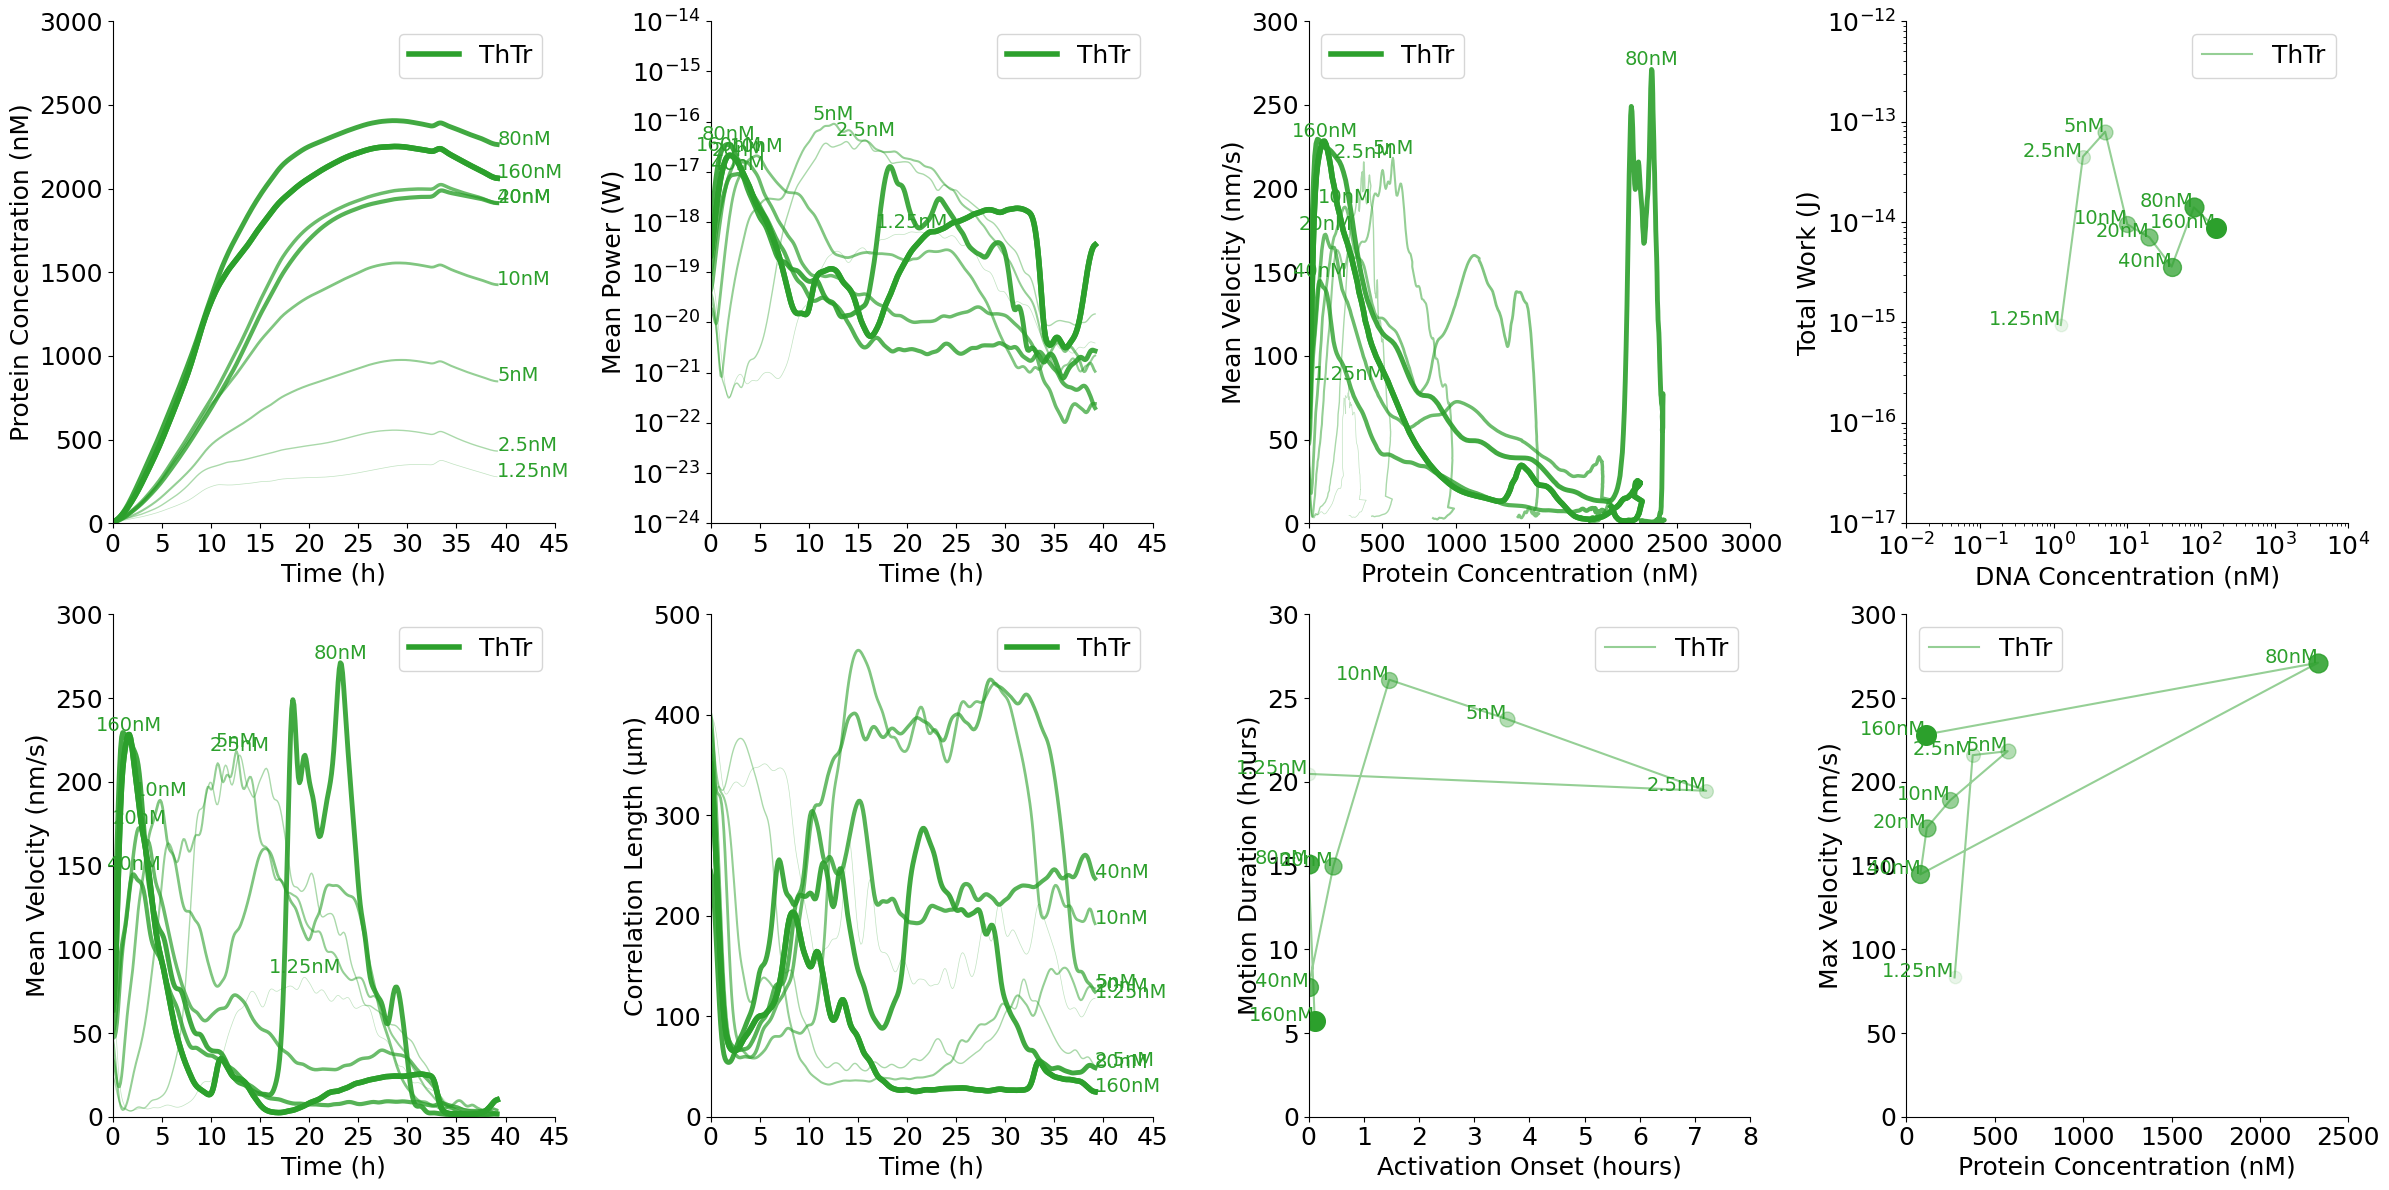

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def generate_plots(df, protein_time_ranges, dna_concentrations, output_dir, velocity_threshold=0.2, time_unit='h', colored_DNAnM=True, combined_plots=False, display_dna_text=True):
    """
    Generates plots for selected proteins based on the given parameters.

    Parameters:
    - df: DataFrame containing experimental data
    - protein_time_ranges: Dictionary with protein names as keys and time range tuples as values (in minutes)
    - dna_concentrations: List of DNA concentrations in nM to filter the data
    - output_dir: Directory to save the plots
    - time_unit: 'min' or 'h' for x-axis
    - colored_DNAnM: Boolean to determine if DNA concentration text should be colored according to protein
    - combined_plots: Boolean to determine if all plots should be outputted together in a 2x4 grid
    - display_dna_text: Boolean to determine if DNA concentration text should be displayed inside the plots
    """
    
    # Define color map for proteins
    color_map = {
        'A': '#1f77b4', 'B': '#7f7f7f', 'C': '#2ca02c', 'D': '#d62728',
        'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#ff7f0e',
        'A': '#1f77b4', 'B': '#7f7f7f', 'ThTr': '#2ca02c', 'AcSu2': '#d62728',
        'DiPu': '#9467bd', 'Blesto': '#8c564b', 'G': '#e377c2', 'H': '#ff7f0e'
    }
    
    # Determine time column
    time_col = 'Time_min' if time_unit == 'min' else 'Time_h'

    # Create output directory for the current DNA concentration and proteins
    proteins_str = '_'.join(protein_time_ranges.keys())
    dna_output_dir = os.path.join(output_dir, f'{proteins_str}_Combined_DNA')
    os.makedirs(dna_output_dir, exist_ok=True)

    # Define figure size for all plots
    fig_size = (6, 6)

    if combined_plots:
        fig, axes = plt.subplots(2, 4, figsize=(24, 12))
        axes = axes.flatten()
        plot_idx = 0

    def save_or_show_plot(plot_name):
        nonlocal plot_idx
        if combined_plots:
            axes[plot_idx].set_xlabel(plt.gca().get_xlabel(), fontsize=18)
            axes[plot_idx].set_ylabel(plt.gca().get_ylabel(), fontsize=18)
            axes[plot_idx].set_xticks(plt.gca().get_xticks())
            axes[plot_idx].set_yticks(plt.gca().get_yticks())
            axes[plot_idx].set_xlim(plt.gca().get_xlim())
            axes[plot_idx].set_ylim(plt.gca().get_ylim())
            axes[plot_idx].legend(fontsize=18)
            axes[plot_idx].spines['top'].set_visible(False)
            axes[plot_idx].spines['right'].set_visible(False)
            plot_idx += 1
        else:
            plt.tight_layout()
            plt.savefig(os.path.join(dna_output_dir, plot_name), dpi=500)
            plt.show()

    # Plot Protein Concentration vs. Time
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        for i, dna_concentration in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['Protein Concentration_nM', 'Time_h'])
            smoothed_concentration = gaussian_filter1d(df_filtered['Protein Concentration_nM'], sigma=3)
            alpha = 1.0 - (i * 0.1)
            linewidth = 4.0 - (i * 0.5)
            plt.plot(df_filtered['Time_h'], smoothed_concentration, 
                     color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
            # Add DNA concentration label at the right of the last data point
            if display_dna_text and not df_filtered.empty:
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(df_filtered['Time_h'].iloc[-1], smoothed_concentration[-1], f'{dna_concentration}nM', fontsize=14, ha='left', color=text_color)
            if i == 0:
                plt.plot(df_filtered['Time_h'], smoothed_concentration, label=protein, 
                         color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)

    plt.xlabel('Time (h)', fontsize=18)
    plt.ylabel('Protein Concentration (nM)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.legend(fontsize=18)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    save_or_show_plot('Protein_Concentration_vs_Time.svg')

    # Plot Mean Power vs. Time
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        for i, dna_concentration in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['power [W]_mean', time_col])
            if time_range and time_range != (None, None):
                df_filtered = df_filtered[(df_filtered['Time_min'] >= time_range[0]) & (df_filtered['Time_min'] <= time_range[1])]
            smoothed_power = gaussian_filter1d(df_filtered['power [W]_mean'], sigma=3)
            alpha = 1.0 - (i * 0.1)
            linewidth = 4.0 - (i * 0.5)
            plt.plot(df_filtered[time_col], smoothed_power, 
                     color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
            # Add DNA concentration label at the peak of the power
            if display_dna_text and not df_filtered.empty:
                peak_power_idx = smoothed_power.argmax()
                peak_power_time = df_filtered[time_col].iloc[peak_power_idx]
                peak_power_value = smoothed_power[peak_power_idx]
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(peak_power_time, peak_power_value, f'{dna_concentration}nM', fontsize=14, ha='center', va='bottom', color=text_color)
            if i == 0:
                plt.plot(df_filtered[time_col], smoothed_power, label=protein, 
                         color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
    
    plt.xlabel(f'Time ({time_unit})', fontsize=18)
    plt.ylabel('Mean Power (W)', fontsize=18)
    plt.yscale('log')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18)
    save_or_show_plot('Mean_Power_vs_Time.svg')

    # Plot Mean Velocity vs. Protein Concentration
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        for i, dna_concentration in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['velocity magnitude [m/s]_mean', 'Protein Concentration_nM'])
            if time_range and time_range != (None, None):
                df_filtered = df_filtered[(df_filtered['Time_min'] >= time_range[0]) & (df_filtered['Time_min'] <= time_range[1])]
            smoothed_velocity = gaussian_filter1d(df_filtered['velocity magnitude [m/s]_mean'] * 1e9, sigma=3)
            alpha = 1.0 - (i * 0.1)
            linewidth = 4.0 - (i * 0.5)
            plt.plot(df_filtered['Protein Concentration_nM'], smoothed_velocity, 
                     color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
            # Add DNA concentration label at the peak of the velocity
            if display_dna_text and not df_filtered.empty:
                peak_velocity_idx = smoothed_velocity.argmax()
                peak_velocity_time = df_filtered['Protein Concentration_nM'].iloc[peak_velocity_idx]
                peak_velocity_value = smoothed_velocity[peak_velocity_idx]
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(peak_velocity_time, peak_velocity_value, f'{dna_concentration}nM', fontsize=14, ha='center', va='bottom', color=text_color)
            if i == 0:
                plt.plot(df_filtered['Protein Concentration_nM'], smoothed_velocity, label=protein, 
                         color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
    
    plt.xlabel('Protein Concentration (nM)', fontsize=18)
    plt.ylabel('Mean Velocity (nm/s)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18)
    save_or_show_plot('Mean_Velocity_vs_Protein_Concentration.svg')

    # Plot Total Work vs. DNA Concentration
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        if protein in df['protein'].unique():
            protein_data = df[df['protein'] == protein]
            dna_concs, total_works = [], []

            for dna_conc in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
                data = protein_data[protein_data['DNA nM'] == str(dna_conc)]
                work_data = data['work [J]_mean'].dropna()
                if len(work_data) > 0:
                    dna_concs.append(float(dna_conc))
                    total_works.append(work_data.iloc[-1])

            alphas = np.linspace(1.0, 0.1, len(dna_concs))
            sizes = np.linspace(200, 80, len(dna_concs))
            for i, (x, y, alpha, size) in enumerate(zip(dna_concs, total_works, alphas, sizes)):
                plt.scatter(x, y, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    plt.text(x, y, f'{x if x % 1 != 0 else int(x)}nM', fontsize=14, ha='right', color=text_color)  # Add DNA concentration labels
            plt.plot(dna_concs, total_works, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)

    plt.xlabel('DNA Concentration (nM)', fontsize=18)
    plt.ylabel('Total Work (J)', fontsize=18)
    plt.yscale('log')
    plt.xticks(np.arange(0, max(dna_concs) + 40, 40), fontsize=18)
    plt.yticks(fontsize=18)
    plt.xscale('log')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(loc='lower right', fontsize=18)
    save_or_show_plot('Total_Work_vs_DNA_Concentration.svg')

    # Plot Mean Velocity vs. Time
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        for i, dna_concentration in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['velocity magnitude [m/s]_mean', time_col])
            if time_range and time_range != (None, None):
                df_filtered = df_filtered[(df_filtered['Time_min'] >= time_range[0]) & (df_filtered['Time_min'] <= time_range[1])]
            smoothed_velocity = gaussian_filter1d(df_filtered['velocity magnitude [m/s]_mean'] * 1e9, sigma=3)
            alpha = 1.0 - (i * 0.1)
            linewidth = 4.0 - (i * 0.5)
            plt.plot(df_filtered[time_col], smoothed_velocity, 
                     color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
            # Add DNA concentration label at the peak of the velocity
            if display_dna_text and not df_filtered.empty:
                peak_velocity_idx = smoothed_velocity.argmax()
                peak_velocity_time = df_filtered[time_col].iloc[peak_velocity_idx]
                peak_velocity_value = smoothed_velocity[peak_velocity_idx]
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(peak_velocity_time, peak_velocity_value, f'{dna_concentration}nM', fontsize=14, ha='center', va='bottom', color=text_color)
            if i == 0:
                plt.plot(df_filtered[time_col], smoothed_velocity, label=protein, 
                         color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)

    plt.xlabel(f'Time ({time_unit})', fontsize=18)
    plt.ylabel('Mean Velocity (nm/s)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.legend(fontsize=18)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    save_or_show_plot('Mean_Velocity_vs_Time.svg')

    # Plot Correlation Length vs. Time
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        for i, dna_concentration in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['correlation length [m]_mean', time_col])
            if time_range and time_range != (None, None):
                df_filtered = df_filtered[(df_filtered['Time_min'] >= time_range[0]) & (df_filtered['Time_min'] <= time_range[1])]
            smoothed_correlation_length = gaussian_filter1d(df_filtered['correlation length [m]_mean'], sigma=3)
            alpha = 1.0 - (i * 0.1)
            linewidth = 4.0 - (i * 0.5)
            plt.plot(df_filtered[time_col], smoothed_correlation_length * 1e6, 
                     color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
            # Add DNA concentration label at the right of the last data point
            if display_dna_text and not df_filtered.empty:
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(df_filtered[time_col].iloc[-1], smoothed_correlation_length[-1] * 1e6, f'{dna_concentration}nM', fontsize=14, ha='left', color=text_color)
            if i == 0:
                plt.plot(df_filtered[time_col], smoothed_correlation_length * 1e6, label=protein, 
                         color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
    
    plt.xlabel(f'Time ({time_unit})', fontsize=18)
    plt.ylabel('Correlation Length (µm)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18)
    save_or_show_plot('Correlation_Length_vs_Time.svg')

    # Plot Motion Duration vs. Activation Onset
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    max_motion_duration = 0  # Initialize a variable to track the maximum motion duration
    for protein, time_range in protein_time_ranges.items():
        motion_durations = []
        activation_onsets = []
        dna_labels = []
        for dna_conc in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            df_protein = df[(df['protein'] == protein) & (df['DNA nM'] == str(dna_conc))].dropna(subset=['velocity magnitude [m/s]_mean', time_col])
            if time_range and time_range != (None, None):
                df_protein = df_protein[(df_protein['Time_min'] >= time_range[0]) & (df_protein['Time_min'] <= time_range[1])]
            
            # Apply Gaussian filter with sigma=3
            smoothed_velocity = gaussian_filter1d(df_protein['velocity magnitude [m/s]_mean'], sigma=3)
            df_protein['smoothed_velocity'] = smoothed_velocity
            
            peak_velocity = df_protein['smoothed_velocity'].max()
            threshold_velocity = velocity_threshold * peak_velocity  # 40% of peak velocity
            above_threshold = df_protein[df_protein['smoothed_velocity'] >= threshold_velocity]
            if not above_threshold.empty:
                activation_onset = above_threshold[time_col].iloc[0]  # Time where velocity first surpasses threshold
                motion_duration = above_threshold[time_col].count() * (df_protein[time_col].diff().mean())  # Cumulative time
                activation_onsets.append(activation_onset)
                motion_durations.append(motion_duration)
                dna_labels.append(f'{dna_conc}nM')
                max_motion_duration = max(max_motion_duration, motion_duration)  # Update max motion duration
        
        if motion_durations:
            alphas = np.linspace(1.0, 0.1, len(motion_durations))
            sizes = np.linspace(200, 80, len(motion_durations))
            for i, (x, y, alpha, size, label) in enumerate(zip(activation_onsets, motion_durations, alphas, sizes, dna_labels)):
                plt.scatter(x, y, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(x, y, label, fontsize=14, ha='right', color=text_color)
            plt.plot(activation_onsets, motion_durations, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)

    # Determine the x-axis label based on the time unit
    if time_unit == 'min':
        plt.xlabel('Activation Onset (minutes)', fontsize=18)
        plt.ylabel('Motion Duration (minutes)', fontsize=18)
    else:
        plt.xlabel('Activation Onset (hours)', fontsize=18)
        plt.ylabel('Motion Duration (hours)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0, top=max_motion_duration + 1)  # Set y-axis limit to 1 hour more than the top motion duration
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18)
    save_or_show_plot('Motion_Duration_vs_Activation_Onset.svg')

    # Plot Max Velocity vs. Protein Concentration
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        max_velocities = []
        protein_concs = []
        dna_labels = []  # To store DNA concentration labels
        for dna_concentration in sorted(dna_concentrations, reverse=True):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['velocity magnitude [m/s]_mean', 'Protein Concentration_nM'])
            if time_range and time_range != (None, None):
                df_filtered = df_filtered[(df_filtered['Time_min'] >= time_range[0]) & (df_filtered['Time_min'] <= time_range[1])]
            smoothed_velocity = gaussian_filter1d(df_filtered['velocity magnitude [m/s]_mean'] * 1e9, sigma=3)
            if not df_filtered.empty:
                peak_velocity_idx = smoothed_velocity.argmax()
                peak_velocity_value = smoothed_velocity[peak_velocity_idx]
                protein_conc_at_peak = df_filtered['Protein Concentration_nM'].iloc[peak_velocity_idx]
                max_velocities.append(peak_velocity_value)
                protein_concs.append(protein_conc_at_peak)
                # Format DNA concentration label
                if float(dna_concentration).is_integer():
                    dna_labels.append(f'{int(dna_concentration)}nM')
                else:
                    dna_labels.append(f'{dna_concentration}nM')
        
        if max_velocities:
            alphas = np.linspace(1.0, 0.1, len(max_velocities))
            sizes = np.linspace(200, 80, len(max_velocities))
            for i, (x, y, alpha, size, label) in enumerate(zip(protein_concs, max_velocities, alphas, sizes, dna_labels)):
                plt.scatter(x, y, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(x, y, label, fontsize=14, ha='right', color=text_color)
            plt.plot(protein_concs, max_velocities, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)

    plt.xlabel('Protein Concentration (nM)', fontsize=18)
    plt.ylabel('Max Velocity (nm/s)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18)
    save_or_show_plot('Max_Velocity_vs_Protein_Concentration.svg')

    if combined_plots:
        plt.tight_layout()
        plt.savefig(os.path.join(dna_output_dir, 'Combined_Plots.svg'), dpi=500)
        plt.show()


# Example usage:
protein_time_ranges = {
    # 'A': (60*6, 60*30), 
    # 'C': (60*2, 60*40),
    # 'B': (None, None),
    # 'D': (5, 120),
    # 'E': (None, None),
    # 'F': (None, None),
    # 'G': (60, 60*25),
    # 'H': (5, 80),
    'ThTr': (None, None),
    # 'AcSu2': (None, None),
    # 'DiPu': (0, 8*60),
}  # Time ranges in minutes

titrations = [160 / (2 ** i) for i in range(11)]
titrations = [int(t) if t.is_integer() else t for t in titrations][:8:]
print(titrations)

generate_plots(df, protein_time_ranges, dna_concentrations=titrations, output_dir='../../../Downloads/Selected_Proteins_Plots', velocity_threshold=0.3, time_unit='h', colored_DNAnM=True, combined_plots=True, display_dna_text=True)
